In [1]:
import glob
from shutil import copyfile, move
import os, re
import numpy as np
import random
import argparse

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# parser = argparse.ArgumentParser(description="split all im-json set to train and val", )

# parser.add_argument('-d', "--data", default='./', help='path to data dir, default=./', metavar='')
# parser.add_argument('-p', "--proportion", default=.2, type=float, help='proportion of test set, default=.2', metavar='')


# args = parser.parse_args()

# PATH_TO_DATA = args.data
# PROPORTION = args.proportion

In [28]:
# im_path = '../data/interim/K_labeling/done/'
# ims = glob.glob(im_path + '*/*')

# for im in ims:
#     jname = im.split('/')[-1].replace('jpg','json')
#     src = '../data/interim/K_labeling/files_for_set3/{}'.format(jname)
#     dst = im.replace('jpg','json')
#     try:
#         copyfile(src,dst)
#     except:
#         pass

In [32]:
PATH_TO_DATA = '../data/interim/training/_labelme_set_3/'
PROPORTION = .3

In [33]:
def create_dir(path):
    if not os.path.exists(path):
        os.mkdir(path)

In [34]:
def count_labels_in_file(filename, label_name='cell'):
    # equal to "grep -c $label_name $filename"
    counter = 0
    with open(filename) as file:
        for line in file:
            if label_name in line:
                counter += 1
    return counter

In [35]:
images = glob.glob(os.path.join(PATH_TO_DATA, '*.jpg'))
# random.shuffle(images)
labels = [im.replace('jpg', 'json') for im in images]

In [36]:
cell_numbers = []
for im,jsn in zip(images, labels):
    n_labels = count_labels_in_file(jsn)
    cell_numbers.append(n_labels)
    
cell_numbers = np.array(cell_numbers) # nums of cells in each image

In [37]:
cell_numbers

array([ 34,  15,  14,  22,  16,   1,   3,   2,   6,  50,   5,   5,  64,
         4,   1,   0,   3,  18,   0,   2,  44,   0, 219,   1,   2,   3,
         7,   4,  35,   9,   1,   3,  76,  26, 123,   3,  10,   2,  11,
         4,   1,   5,  32,   2,  10,  21,   5, 139,  50,  37,   6,   4,
        10,  21,   1,   1,  17,   4,   1,   2,  51,  13,   1,   1,   1,
         1,   2,  16,   7,   4,   1,   2,   3,  40,  28,   5, 158,  18,
         8,   2,  14,   2,   2,   3,   2,   0,  43,   1,  24,  12,  53,
         3,   2,  74,   8,   2,  18,   8,  71,   3,  66, 101,   1,   8,
       112,   5,  12,   9,   2,   9,   0,  10,   6,  15,   4,   0,   7,
        46,  55,   9,  17,   2,   3,   7,  75,   2,  41,   2,   1,  63,
         1,  13,   5,  26,   5,   1,  37,  66,  19,  14,  31,   2,  10,
        12,   1,   1,  26,   1,  99,   0,   3,  19,  18,  21,   2,  83,
         6,   7,   1,   2,   5,  54,   6,  10,  20,  34,   1,   2,   3,
        81,  15,   1,   5, 175,   2,   1,  43,  28,   3,   2,   

In [38]:
# here we get discrete cell density 
n_bins = 5
dens,vals = np.histogram(cell_numbers, bins=n_bins, weights=cell_numbers)
probs = (dens + 100) / dens.sum() # add 100 for smoothing
dens,probs,vals

(array([1604, 1257,  531,  612,  219]),
 array([0.40350462, 0.32133554, 0.14941984, 0.16860052, 0.07553872]),
 array([  0. ,  43.8,  87.6, 131.4, 175.2, 219. ]))

In [39]:
sampling_probs = [] # probs to sample for each N in cell_numbers
for x in cell_numbers:
    for i,v in enumerate(vals):
        if x < v:
            cur_prob = probs[i-1]
            break
    sampling_probs.append(cur_prob)

sampling_probs = np.array(sampling_probs) / sum(sampling_probs)

In [40]:
n_test = int(len(images) * PROPORTION)

test_set = np.random.choice(images, n_test, p=sampling_probs, replace=False) # sampling w/o repeats
test_cell_numbers = [count_labels_in_file(im.replace('jpg', 'json')) for im in test_set]

In [41]:
train_set = set(images).difference(test_set)
train_cell_numbers = [count_labels_in_file(im.replace('jpg', 'json')) for im in train_set]

len(test_set) + len(train_set) == len(images), len(set(test_set).union(train_set)) == len(images)

(True, True)

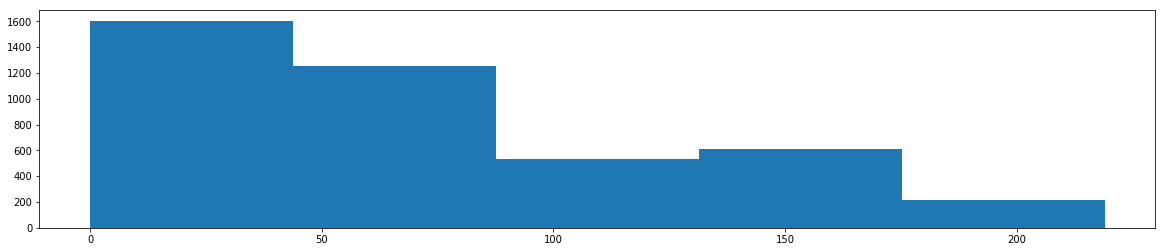

In [42]:
plt.figure(figsize=(20,4))
_ = plt.hist(cell_numbers, n_bins, weights=cell_numbers)

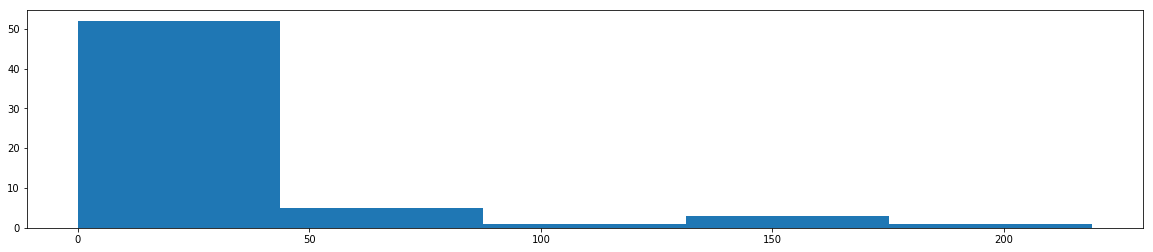

In [43]:
plt.figure(figsize=(20,4))
_ = plt.hist(test_cell_numbers, n_bins)

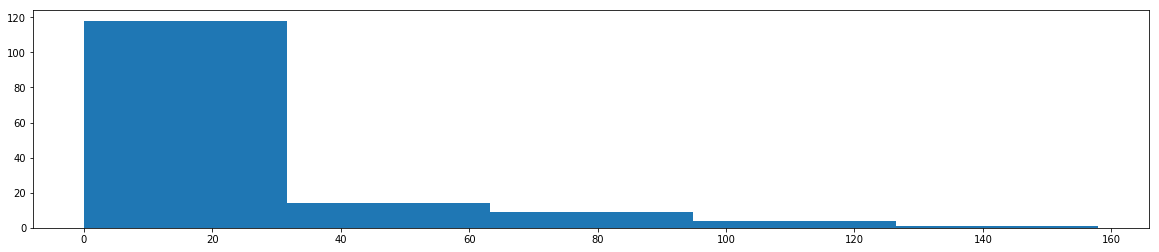

In [44]:
plt.figure(figsize=(20,4))
_ = plt.hist(train_cell_numbers, n_bins)

### Sets have created. It's time to sort it in dirs

In [45]:
im_heap = dict(test=test_set, train=train_set)

In [46]:
create_dir(os.path.join(PATH_TO_DATA, 'test'))
create_dir(os.path.join(PATH_TO_DATA, 'train'))

In [47]:
for part in im_heap:
    for src_im in im_heap[part]:
        src_jsn = src_im.replace('jpg', 'json')
        
        dst_im = os.path.join(PATH_TO_DATA, part, src_im.split('/')[-1])
        dst_jsn = dst_im.replace('jpg','json')
        
        move(src_im, dst_im)
        move(src_jsn, dst_jsn)